# Experiment: Learning a 3D LUT with a CNN
In this first experiment, the goal is to prove the general learnability and generation of 3D LUTs with a Convolutional Neural Network (CNN). The CNN receives an RGB image as input and outputs a 3D LUT instead of an image as in the FilmGAN experiment (https://www.researchgate.net/publication/376411929_Film-GAN_towards_realistic_analog_film_photo_generation). The underlying assumption of the experiment is that the generation of a 3D LUT is comparable to the generation of images.
To prove the general learnability of 3D LUTs, we attempt to learn a LUT that was used to transform a set of images. The dataset for this experiment consists of paired images, the original images, and the same images after the application of a black-and-white LUT. The image resolution is 256 x 256 pixels with 3 channels (RGB).

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
from IPython.display import display
import os
from torchinfo import summary
from pytorch_msssim import ssim, ms_ssim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters

In [3]:
batch_size = 64
lut_size = 33
learning_rate = 1e-2
num_epochs = 500
use_interpolation = True
experiment = "bw_w_interpolation"
model_name = "img2lut_bw_w_interpolation.pth.tar"

# Dataset
The Dataset for this Experiment consists of paired images, the original images, and the same images after the application of a black-and-white LUT.

In [4]:
class PairedImageDataset(Dataset):
    def __init__(self, ungraded_images, graded_images, transform=None):
        self.ungraded_images = ungraded_images
        self.graded_images = graded_images
        self.transform = transform

    def __len__(self):
        return len(self.ungraded_images)

    def __getitem__(self, idx):
        # Returns an ungraded and a graded image
        ungraded = self.ungraded_images[idx]
        graded = self.graded_images[idx]
        if self.transform:
            ungraded = self.transform(ungraded)
            graded = self.transform(graded)
        return ungraded, graded

In [5]:
transform64 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

The function `load_images_from_directory` gets all images that are within a specific directory, converts them into RGB and can apply a transformation to the images. Additionally the number of images that are processed can be limited with the `num_images` parameter. The function returns a tensor of images. The tensor has the shape (number of images x width x height x channels). 

In [7]:
def load_images_from_directory(directory_path, num_images=100, apply_transform=True):
    images = []
    files = os.listdir(directory_path)
    # Ensure only images are processed
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for i, image_file in enumerate(image_files[:num_images]):
        image_path = os.path.join(directory_path, image_file)
        img = Image.open(image_path).convert('RGB')  # Convert to RGB in case of grayscale
        if apply_transform:
            img = transform64(img)  # Apply the transformations

        else:
            img = transform(img)
        images.append(img)
        
    images_tensor = torch.stack(images)
    images_tensor = images_tensor.permute(0, 2, 3, 1)
    return images_tensor

ungraded_images = load_images_from_directory('../../analogdb_images_scaled/kodak_ultramax', num_images=400)
graded_images = load_images_from_directory('../../analogdb_images_scaled/kodak_ultramax/BW', num_images=400)

# Verify the shape of the tensors
print(ungraded_images.shape)  
print(graded_images.shape)

torch.Size([317, 256, 256, 3])
torch.Size([317, 256, 256, 3])


As we can see above, for this experiment we use 317 images.

In [8]:
ungraded_images_np = ungraded_images.numpy()
graded_images_np = graded_images.numpy()

dataset = PairedImageDataset(ungraded_images_np, graded_images_np, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Visualization of the Dataset

In [9]:
# Function to plot a set of images in a 8x8 grid
def plot_image_grid(images, title):
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(vutils.make_grid(images.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()

## Original training Images
The following Image Grid shows the original training images:

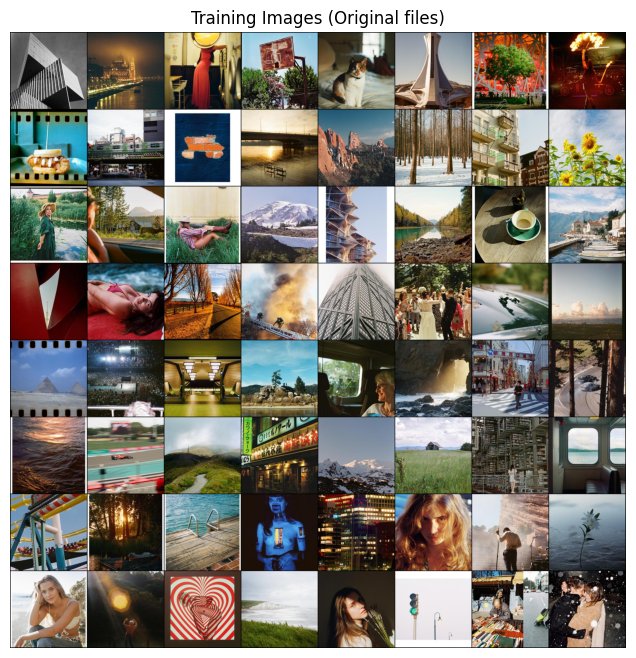

In [10]:
ungraded, graded = next(iter(dataloader))

plot_image_grid(ungraded, "Training Images (Original files)")

## Edited training Images
The following Image Grid shows the edited training images:

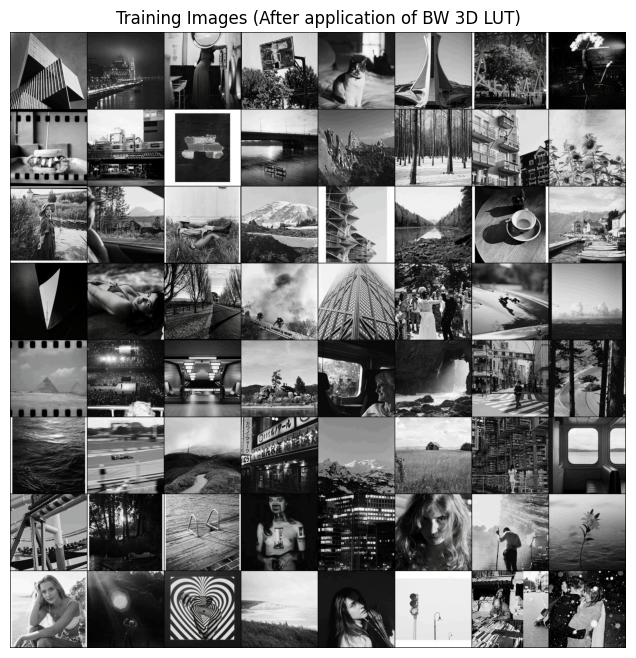

In [11]:
plot_image_grid(graded, "Training Images (After application of BW 3D LUT)")

# Apply LUT function

In [28]:
def trilinear_interpolation(luts, images):
    # Ensure LUT is reshaped properly (N, size, size, size, 3)
    lut = luts.view(luts.shape[0], luts.shape[2], luts.shape[2], luts.shape[2], 3)
    
    # Normalize image to range [0, lut_size - 1]
    lut_size = luts.shape[2]
    image_normalized = (images * (lut_size - 1))
    image_normalized = torch.clamp(image_normalized, 0, lut_size - 1)

    # Get the integer floor and ceil indices for each channel
    r_floor = image_normalized[:, 0, :, :].floor().long()
    g_floor = image_normalized[:, 1, :, :].floor().long()
    b_floor = image_normalized[:, 2, :, :].floor().long()

    r_ceil = torch.clamp(r_floor + 1, 0, lut_size - 1)
    g_ceil = torch.clamp(g_floor + 1, 0, lut_size - 1)
    b_ceil = torch.clamp(b_floor + 1, 0, lut_size - 1)

    # Calculate interpolation weights
    r_weight = image_normalized[:, 0, :, :] - r_floor.float()
    g_weight = image_normalized[:, 1, :, :] - g_floor.float()
    b_weight = image_normalized[:, 2, :, :] - b_floor.float()

    # Helper function to gather LUT values
    def gather_lut(lut, r, g, b):
        return lut[torch.arange(lut.shape[0]).unsqueeze(-1).unsqueeze(-1), r, g, b]

    # Perform trilinear interpolation (8 corners of the cube)
    c000 = gather_lut(lut, r_floor, g_floor, b_floor)
    c001 = gather_lut(lut, r_floor, g_floor, b_ceil)
    c010 = gather_lut(lut, r_floor, g_ceil, b_floor)
    c011 = gather_lut(lut, r_floor, g_ceil, b_ceil)
    c100 = gather_lut(lut, r_ceil, g_floor, b_floor)
    c101 = gather_lut(lut, r_ceil, g_floor, b_ceil)
    c110 = gather_lut(lut, r_ceil, g_ceil, b_floor)
    c111 = gather_lut(lut, r_ceil, g_ceil, b_ceil)

    # Interpolate along the R axis
    c00 = c000 * (1 - r_weight).unsqueeze(-1) + c100 * r_weight.unsqueeze(-1)
    c01 = c001 * (1 - r_weight).unsqueeze(-1) + c101 * r_weight.unsqueeze(-1)
    c10 = c010 * (1 - r_weight).unsqueeze(-1) + c110 * r_weight.unsqueeze(-1)
    c11 = c011 * (1 - r_weight).unsqueeze(-1) + c111 * r_weight.unsqueeze(-1)

    # Interpolate along the G axis
    c0 = c00 * (1 - g_weight).unsqueeze(-1) + c10 * g_weight.unsqueeze(-1)
    c1 = c01 * (1 - g_weight).unsqueeze(-1) + c11 * g_weight.unsqueeze(-1)

    # Interpolate along the B axis
    transformed = c0 * (1 - b_weight).unsqueeze(-1) + c1 * b_weight.unsqueeze(-1)

    # Permute to (N, C, H, W) format
    transformed = transformed.permute(0, 3, 1, 2)

    return transformed

In [29]:
def simple_approach(luts, images):
    lut = luts.view(luts.shape[0], luts.shape[2], luts.shape[2], luts.shape[2], 3)
    image_normalized = (images * luts.shape[2]-1).long()
    image_normalized = torch.clamp(image_normalized, 0, luts.shape[2]-1)
        
    r = image_normalized[:, 0, :, :]
    g = image_normalized[:, 1, :, :]
    b = image_normalized[:, 2, :, :]
        
    transformed = lut[torch.arange(luts.shape[0]).unsqueeze(-1).unsqueeze(-1), r, g, b]
    transformed = transformed.permute(0, 3, 1, 2)

## Comparison of the complexity of the simple and trilinear approach

In [48]:
import time
start_time = time.time()

for i in range(10):
    test_apply_images = simple_approach(torch.rand(1000, 33, 33, 33, 3).to(device), torch.rand(1000, 3, 256, 256).to(device))

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 15.816830396652222 seconds


In [49]:
start_time = time.time()
for i in range(10):
    test_apply_images = trilinear_interpolation(torch.rand(1000, 33, 33, 33, 3).to(device), torch.rand(1000, 3, 256, 256).to(device))

end_time = time.time()
elapsed_time_trilinear = end_time - start_time
print(f"Elapsed time: {elapsed_time_trilinear} seconds")

Elapsed time: 66.73210763931274 seconds


In [50]:
print(f"trilinear_interpolation takes {(elapsed_time_trilinear/elapsed_time)}x as much time.")

trilinear_interpolation takes 4.219056913794638x as much time.


# ResNet
The model used for this experiment is based on the Residual Network (ResNet) architecture proposed in the paper `Deep Residual Learning for Image Recognition`: https://arxiv.org/pdf/1512.03385

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)
        return F.relu(out)

Instead of the initial 7x7 convolutional layer, we use a 3x3 filter with a padding of one in the initial convolutional layer that keeps the initial resolution, in this case at 256 x 256. As another measure to adapt the model to lower image resolutions, we use just three residual blocks in comparison to four in the original implementation.
The residual blocks are identical to the ResNet implementation with a filter size of 3x3. Just as mentioned in the paper, "when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2".
In general, convolutional layers are followed by batch normalization and a ReLU activation function as in the original implementation. After the residual blocks, global average pooling is performed, also following the original implementation.
Where the original implementation ends with a 1000-way fully connected layer with a softmax activation function for the task of classifying the 1000 classes in the ImageNet 2012 classification dataset, our model is adopted to generate 3D LUTs. The global average pooling layer is followed by a fully connected layer with 512 dimensions followed by ReLU activation and another fully connected layer that expands the output to the required dimensions for the 3D LUT, which is: LUT_size^3 * channels. The model can be initialized with varying LUT sizes; for an 8 bit LUT the last fully connected layer has 8 * 8 * 8 * 3 = 1536 dimensions.

Source: https://arxiv.org/pdf/1512.03385

In [34]:
class ResNetLUTGenerator(nn.Module):
    def __init__(self, lut_size=8, trilinear=True, input_channels=3):
        super(ResNetLUTGenerator, self).__init__()
        self.lut_size = lut_size
        self.trilinear = trilinear
        
        # Initial convolution
        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        # ResNet feature extraction
        self.layer1 = self._make_layer(32, 64, stride=2)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # LUT generator
        self.lut_generator = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, lut_size * lut_size * lut_size * 3)
        )

    def _make_layer(self, in_channels, out_channels, stride):
        return ResidualBlock(in_channels, out_channels, stride)


    def _trilinear_interpolation(self, luts, images):
        # Ensure LUT is reshaped properly (N, size, size, size, 3)
        lut = luts.view(luts.shape[0], luts.shape[2], luts.shape[2], luts.shape[2], 3)
        
        # Normalize image to range [0, lut_size - 1]
        lut_size = luts.shape[2]
        image_normalized = (images * (lut_size - 1))
        image_normalized = torch.clamp(image_normalized, 0, lut_size - 1)
    
        # Get the integer floor and ceil indices for each channel
        r_floor = image_normalized[:, 0, :, :].floor().long()
        g_floor = image_normalized[:, 1, :, :].floor().long()
        b_floor = image_normalized[:, 2, :, :].floor().long()
    
        r_ceil = torch.clamp(r_floor + 1, 0, lut_size - 1)
        g_ceil = torch.clamp(g_floor + 1, 0, lut_size - 1)
        b_ceil = torch.clamp(b_floor + 1, 0, lut_size - 1)
    
        # Calculate interpolation weights
        r_weight = image_normalized[:, 0, :, :] - r_floor.float()
        g_weight = image_normalized[:, 1, :, :] - g_floor.float()
        b_weight = image_normalized[:, 2, :, :] - b_floor.float()
    
        # Helper function to gather LUT values
        def gather_lut(lut, r, g, b):
            return lut[torch.arange(lut.shape[0]).unsqueeze(-1).unsqueeze(-1), r, g, b]
    
        # Perform trilinear interpolation (8 corners of the cube)
        c000 = gather_lut(lut, r_floor, g_floor, b_floor)
        c001 = gather_lut(lut, r_floor, g_floor, b_ceil)
        c010 = gather_lut(lut, r_floor, g_ceil, b_floor)
        c011 = gather_lut(lut, r_floor, g_ceil, b_ceil)
        c100 = gather_lut(lut, r_ceil, g_floor, b_floor)
        c101 = gather_lut(lut, r_ceil, g_floor, b_ceil)
        c110 = gather_lut(lut, r_ceil, g_ceil, b_floor)
        c111 = gather_lut(lut, r_ceil, g_ceil, b_ceil)
    
        # Interpolate along the R axis
        c00 = c000 * (1 - r_weight).unsqueeze(-1) + c100 * r_weight.unsqueeze(-1)
        c01 = c001 * (1 - r_weight).unsqueeze(-1) + c101 * r_weight.unsqueeze(-1)
        c10 = c010 * (1 - r_weight).unsqueeze(-1) + c110 * r_weight.unsqueeze(-1)
        c11 = c011 * (1 - r_weight).unsqueeze(-1) + c111 * r_weight.unsqueeze(-1)
    
        # Interpolate along the G axis
        c0 = c00 * (1 - g_weight).unsqueeze(-1) + c10 * g_weight.unsqueeze(-1)
        c1 = c01 * (1 - g_weight).unsqueeze(-1) + c11 * g_weight.unsqueeze(-1)
    
        # Interpolate along the B axis
        transformed = c0 * (1 - b_weight).unsqueeze(-1) + c1 * b_weight.unsqueeze(-1)
    
        # Permute to (N, C, H, W) format
        transformed = transformed.permute(0, 3, 1, 2)
    
        return transformed

    def _simple_approach(self, luts, images):
        lut = luts.view(luts.shape[0], luts.shape[2], luts.shape[2], luts.shape[2], 3)
        image_normalized = (images * luts.shape[2]-1).long()
        image_normalized = torch.clamp(image_normalized, 0, luts.shape[2]-1)
            
        r = image_normalized[:, 0, :, :]
        g = image_normalized[:, 1, :, :]
        b = image_normalized[:, 2, :, :]
            
        transformed = lut[torch.arange(luts.shape[0]).unsqueeze(-1).unsqueeze(-1), r, g, b]
        transformed = transformed.permute(0, 3, 1, 2)

        return transformed


    def forward(self, x):
        # Feature extraction
        x_orig = x  # Store original input
        x = self.initial_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        # Global pooling and feature compression
        features = self.global_pool(x).view(x.size(0), -1)
        
        # Generate LUT
        lut = self.lut_generator(features)
        lut = lut.view(-1, self.lut_size, self.lut_size, self.lut_size, 3)
        lut = torch.sigmoid(lut)
        
        # Apply LUT to original input
        if self.trilinear:
            transformed = self._trilinear_interpolation(lut, x_orig)
        else:
            transformed = self._simple_approach(lut, x_orig)
        return transformed, lut

## Test LUT Generator

In [35]:
sample_input = torch.rand(4, 3, 256, 256).to(device)
LUTGeneratorCNN=ResNetLUTGenerator().to(device)
transformed, lut = LUTGeneratorCNN(sample_input)
print(lut.shape)
print(transformed.shape)

torch.Size([4, 8, 8, 8, 3])
torch.Size([4, 3, 256, 256])


The models architectural summary for 256 x 256 images and an 8 bit LUT is shown in the summary below, where we can see the initial convolutional layer, followed by the three residual blocks, the global average pooling layer and the fully connected layers for the 3D LUT.

In [36]:
test_model = ResNetLUTGenerator()
summary(test_model, input_size=(32, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
ResNetLUTGenerator                       [32, 3, 256, 256]         --
├─Sequential: 1-1                        [32, 32, 256, 256]        --
│    └─Conv2d: 2-1                       [32, 32, 256, 256]        896
│    └─BatchNorm2d: 2-2                  [32, 32, 256, 256]        64
│    └─ReLU: 2-3                         [32, 32, 256, 256]        --
├─ResidualBlock: 1-2                     [32, 64, 128, 128]        --
│    └─Conv2d: 2-4                       [32, 64, 128, 128]        18,496
│    └─BatchNorm2d: 2-5                  [32, 64, 128, 128]        128
│    └─Conv2d: 2-6                       [32, 64, 128, 128]        36,928
│    └─BatchNorm2d: 2-7                  [32, 64, 128, 128]        128
│    └─Sequential: 2-8                   [32, 64, 128, 128]        --
│    │    └─Conv2d: 3-1                  [32, 64, 128, 128]        2,112
│    │    └─BatchNorm2d: 3-2             [32, 64, 128, 128]        128


# Train Function

In [37]:
def display_image(image, width=256):
    tensor_image = image.detach().cpu()
    # Rearrange to HWC format and scale to [0, 255]
    image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))  # Select the first image in batch and permute to HWC
    image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
            
    image = Image.fromarray(image_np)
    display(image)

In [38]:
def display_images(images, titles=None):
    # Three subplots in one row
    fig, axes = plt.subplots(1, 3, figsize=(4, 2))
    
    # Convert and display each image
    for idx, (ax, img) in enumerate(zip(axes, [images[0], images[1], images[2]])):
        # Convert tensor to numpy array
        tensor_image = img.detach().cpu()
        image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))
        image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
        
        # Display the image
        ax.imshow(image_np)
        ax.axis('off')
        
        # Set title if provided
        if titles and idx < len(titles):
            ax.set_title(titles[idx])
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [39]:
def l2_regularization(lut):
    # Penalize large deviations in LUT values.
    return torch.mean(lut ** 2)

def smoothness_regularization(lut, lambda_smooth=0.001):
    """
    Calculate smoothness regularization for a batch of 3D LUTs that only enforces
    local consistency between neighboring values.
    
    Args:
        lut: Tensor of shape (batch_size, 3, lut_size, lut_size, lut_size)
        lambda_smooth: Smoothness weight factor (should be very small)
    
    Returns:
        Smoothness loss value
    """
    # Calculate differences with immediate neighbors only
    diff_x = torch.abs(lut[:, :, 1:, :, :] - lut[:, :, :-1, :, :])
    diff_y = torch.abs(lut[:, :, :, 1:, :] - lut[:, :, :, :-1, :])
    diff_z = torch.abs(lut[:, :, :, :, 1:] - lut[:, :, :, :, :-1])
    
    # Calculate variance in local 2x2x2 neighborhoods
    # This helps ensure smooth transitions without forcing any particular direction
    local_var_x = torch.var(torch.stack([
        lut[:, :, :-1, :-1, :-1],
        lut[:, :, 1:, :-1, :-1],
    ], dim=-1), dim=-1)
    
    local_var_y = torch.var(torch.stack([
        lut[:, :, :-1, :-1, :-1],
        lut[:, :, :-1, 1:, :-1],
    ], dim=-1), dim=-1)
    
    local_var_z = torch.var(torch.stack([
        lut[:, :, :-1, :-1, :-1],
        lut[:, :, :-1, :-1, 1:],
    ], dim=-1), dim=-1)
    
    # Combine both immediate differences and local variance
    smoothness = (
        diff_x.mean() + diff_y.mean() + diff_z.mean() +  # Immediate neighbor differences
        local_var_x.mean() + local_var_y.mean() + local_var_z.mean()  # Local variance
    )
    
    return smoothness * lambda_smooth

def calc_lut_loss(lut):
    #l2_loss = l2_regularization(lut)
    l2_loss = 0
    smoothness_loss = smoothness_regularization(lut)
    total_loss = 0.1 * l2_loss + 0.1 * smoothness_loss
    return total_loss

In [40]:
def ssim_loss(generated, target):
        """
        Structural Similarity Index Measure loss
        Args:
            generated: Generated image tensor (B, C, H, W)
            target: Target image tensor (B, C, H, W)
        """
        return 1 - ssim(generated, target, data_range=255, size_average=True)

In [41]:
def train_model(model, dataloader, optimizer, criterion, num_epochs=10):
    model.train()
    epoch_losses = [] 

    # Create ReduceLROnPlateau scheduler as in the ResNet paper - divides learning rate by 10 when the error plateaus  https://arxiv.org/pdf/1512.03385
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        for ungraded, graded in dataloader:
            ungraded, graded = ungraded.to(device), graded.to(device)

            # Forward pass
            optimizer.zero_grad()
            transformed, _ = model(ungraded)

            loss = criterion(transformed, graded) #+ ssim_loss(transformed, graded) #+ calc_lut_loss(lut)

            # Backward pass
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_epoch_loss = running_loss / len(dataloader)
        epoch_losses.append(avg_epoch_loss)

        # scheduler step with average loss
        scheduler.step(avg_epoch_loss)
        
        #print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader)}")
        if epoch % 50 == 0:
            display_images([ungraded[0], graded[0], transformed[0]], ["raw", "jpg", "model output"])

    return epoch_losses

# Training

In [42]:
model = ResNetLUTGenerator(lut_size=lut_size, trilinear=use_interpolation).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

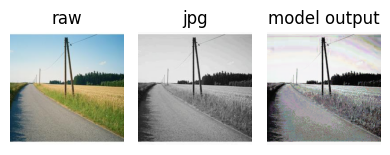

 10%|███████▉                                                                       | 50/500 [13:10<2:06:01, 16.80s/it]

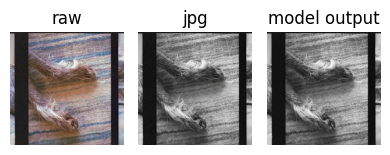

 20%|███████████████▌                                                              | 100/500 [26:46<1:50:53, 16.63s/it]

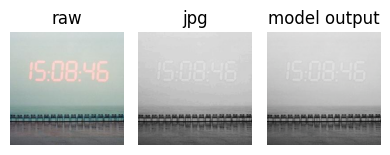

 30%|███████████████████████▍                                                      | 150/500 [39:13<1:25:49, 14.71s/it]

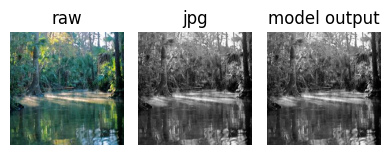

 40%|███████████████████████████████▏                                              | 200/500 [53:13<1:23:34, 16.72s/it]

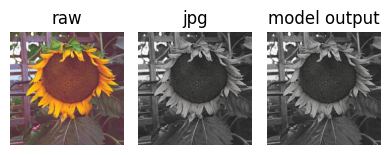

 50%|██████████████████████████████████████                                      | 250/500 [1:08:17<1:09:04, 16.58s/it]

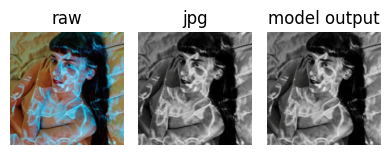

 60%|██████████████████████████████████████████████▊                               | 300/500 [1:22:03<49:22, 14.81s/it]

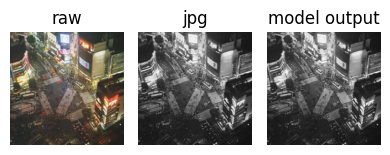

 70%|██████████████████████████████████████████████████████▌                       | 350/500 [1:34:12<35:28, 14.19s/it]

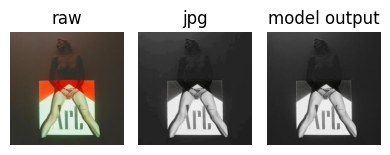

 80%|██████████████████████████████████████████████████████████████▍               | 400/500 [1:46:08<23:41, 14.22s/it]

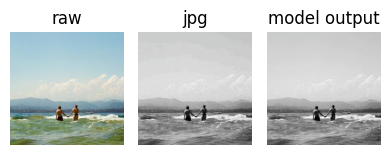

 90%|██████████████████████████████████████████████████████████████████████▏       | 450/500 [1:58:04<11:54, 14.28s/it]

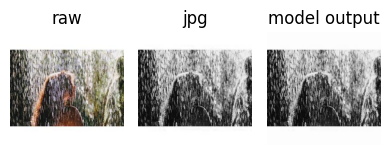

100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [2:11:31<00:00, 15.78s/it]


In [43]:
loss_summary = train_model(model, dataloader, optimizer, criterion, num_epochs)

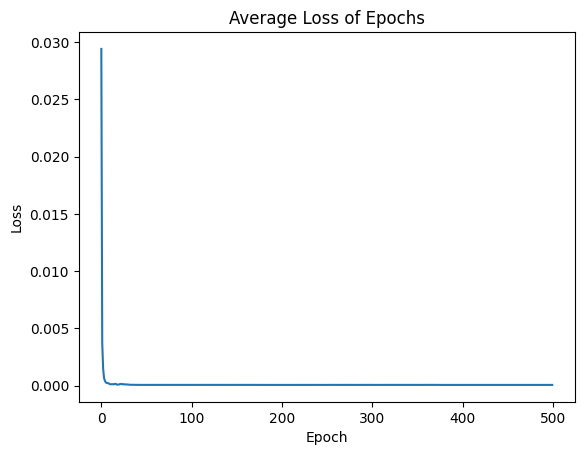

In [44]:
plt.plot(loss_summary)
# Add Title

plt.title("Average Loss of Epochs") 

# Add Axes Labels

plt.xlabel("Epoch") 
plt.ylabel("Loss") 

# Display

plt.show()

In [45]:
print(loss_summary[-1])

7.371695101028308e-05


## Save Model

In [46]:
def save_checkpoint(model, optimizer, directory, filename="models/checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    directory = f"models/{directory}"
    # Create the directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    torch.save(checkpoint, os.path.join(directory, filename))

In [47]:
save_checkpoint(model, optimizer, directory=experiment, filename=model_name)

=> Saving checkpoint
